### 1．インポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from urllib.request import urlopen
import optuna.integration.lightgbm as lgb_o
from scipy.special import comb

### 1.1　クラス

In [2]:
# 訓練データと出馬表データを加工する抽象クラス
class DataProcessor:
    def __init__(self):
        self.data = pd.DataFrame()
        # preprocessing後の変数
        self.data_p = pd.DataFrame()
        # horse_resultsをmergeした後の変数
        self.data_h = pd.DataFrame()
        # pedsをmergeした後の変数
        self.data_pe = pd.DataFrame()
        # カテゴリ変数化した後の変数
        self.data_c = pd.DataFrame()
        
    # 馬の過去成績データの追加
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        self.data_h = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_h = hr.merge_all(self.data_h, n_samples=n_samples)
        self.data_h.drop(['開催'], axis=1, inplace=True)
            
    # 血統データ追加
    def merge_peds(self, peds):
        self.data_pe = self.data_h.merge(peds, left_on='horse_id', right_index=True, how='left')
        self.no_peds = self.data_pe[self.data_pe['peds_0'].isnull()]['horse_id'].unique()
        if len(self.no_peds):
            print('scrape peds at horse_id_list "no_peds"')
    
    # カテゴリ変数の処理
    def process_categorical(self, le_horse, le_jockey, results_m):
        df = self.data_pe.copy()
        
        # ラベルエンコーディング(horse_id, jockey_idを0始まりの整数に変換)
        # horse_id
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        
        # jockey_id
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        # horse_id, jockey_idをcategory型に変換
        df['horse_id'] = df['horse_id'].astype('category')
        df['jockey_id'] = df['jockey_id'].astype('category')
        
        # そのほかのカテゴリ変数をcategory型に変換してからダミー変数化
        weathers = results_m['weather'].unique()
        race_types = results_m['race_type'].unique()
        ground_states = results_m['ground_state'].unique()
        sexes = results_m['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_types)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
        df['性'] = pd.Categorical(df['性'], sexes)
        
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])  
        self.data_c = df

# 予測に使う出馬表データを加工するクラス
class ShutubaTable(DataProcessor):
    def __init__(self, shutuba_tables):
        super(ShutubaTable, self).__init__()
        self.data = shutuba_tables
    
    @classmethod
    def scrape(cls, race_id_list, date):
        data = pd.DataFrame()
        for race_id in tqdm(race_id_list):
            url = f'https://race.netkeiba.com/race/shutuba.html?race_id={race_id}'
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T

            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')

            # race_data
            texts = soup.find('div', attrs={'class': 'RaceData01'}).text
            texts = re.findall(r'\w+', texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                if text in ['曇', '晴', '雨', '小雨', '小雪', '雪']:
                    df['weather'] = [text] * len(df)
                if text in ['良', '稍重', '重']:
                    df['ground_state'] = [text] * len(df)
                if '不' in text:
                    df['ground_state'] = ['不良'] * len(df)
                if '芝' in text:
                    df['race_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['race_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート'] * len(df)
            df['date'] = [date] * len(df)

            # horse_id
            horse_id_list = []
            horse_td_list = soup.find_all('td', attrs={'class': 'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            df['horse_id'] = horse_id_list

            # jockey_id
            jockey_id_list = []
            jockey_td_list = soup.find_all('td', attrs={'class': 'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)
            df['jockey_id'] = jockey_id_list

            df.index = [race_id] * len(df)
            data = data.append(df)
            time.sleep(1)
        
        return cls(data)
    
    # 前処理
    def preprocessing(self):
        df = self.data.copy()
        
        # 性齢を性と年齢に分ける
        df['性'] = df['性齢'].map(lambda x: str(x)[0])
        df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df = df[df['馬体重(増減)'] != '--']
        df['体重'] = df['馬体重(増減)'].str.split('(', expand=True)[0].astype(int)
        df['体重変化'] = df['馬体重(増減)'].str.split('(', expand=True)[1].str[:-1].astype(int)
        
        # 日付をdatetime型に変更
        df['date'] = pd.to_datetime(df['date'])

        # データをint, floatに変換
        df['枠'] = df['枠'].astype(int)
        df['馬番'] = df['馬番'].astype(int)
        df['斤量'] = df['斤量'].astype(int)

    
        # 必要な列だけにする
        df = df[['枠', '馬番', '斤量', 'course_len', 'weather', 'race_type', 'ground_state', 'date', 'horse_id', 'jockey_id', '性', '年齢', '体重', '体重変化']]
        df['開催'] = df.index.map(lambda x:str(x)[4:6])

        self.data_p = df.rename(columns={'枠': '枠番'})

# 訓練に使う過去レースデータを加工するクラス
class Results(DataProcessor):
    def __init__(self, results):
        super(Results, self).__init__()
        self.data = results
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(race_id_list):
        # race_idをkeyにしてDataFrame型を格納
        race_results = {}
        for race_id in tqdm(race_id_list):
            time.sleep(1)
            try:
                url = f'https://db.netkeiba.com/race/{race_id}'
                # メインとなるテーブルデータを取得
                df = pd.read_html(url)[0]

                html = requests.get(url)
                html.encoding = 'EUC-JP'
                soup = BeautifulSoup(html.text, 'html.parser')

                # 天候、レースの種類、コースの長さ、馬場の状態、日付をスクレイピング
                texts = (
                    soup.find('div', attrs={'class': 'data_intro'}).find_all('p')[0].text
                    + soup.find('div', attrs={'class': 'data_intro'}).find_all('p')[1].text
                )
                info = re.findall(r'\w+', texts)
                for text in info:
                    if text in ['芝', 'ダート']:
                        df['race_type'] = [text] * len(df)
                    if '障' in text:
                        df['race_type'] = ['障害'] * len(df)
                    if 'm' in text:
                        df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                    if text in ['良', '稍重', '重', '不良']:
                        df['ground_state'] = [text] * len(df)
                    if text in ['曇', '晴', '雨', '小雨', '小雪', '雪']:
                        df['weather'] = [text] * len(df)
                    if '年' in text:
                        df['date'] = [text] * len(df)

                # 馬ID、騎手IDをスクレイピング
                horse_id_list = []
                horse_a_list = soup.find('table', attrs={'summary': 'レース結果'}).find_all('a', attrs={'href': re.compile('^/horse')})
                for a in horse_a_list:
                    horse_id = re.findall(r'\d+', a['href'])
                    horse_id_list.append(horse_id[0])
                jockey_id_list = []
                jockey_a_list = soup.find("table", attrs={'summary': 'レース結果'}).find_all('a', attrs={'href': re.compile('^/jockey')})
                for a in jockey_a_list:
                    jockey_id = re.findall(r'\d+', a['href'])
                    jockey_id_list.append(jockey_id[0])
                df['horse_id'] = horse_id_list
                df['jockey_id'] = jockey_id_list

                #インデックスをrace_idにする
                df.index = [race_id] * len(df)

                race_results[race_id] = df
            # 存在しないrace_idを飛ばす
            except IndexError:
                continue
            # wifiの接続が切れた時などでも途中までのデータを返せるようにする
            except Exception as e:
                print(e)
                break
            # Jupyterで停止ボタンを押した時の対処
            except:
                break

        # pd.DataFrame型にして一つのデータにまとめる
        race_results_df = pd.concat([race_results[key] for key in race_results])

        return race_results_df
    
    # 前処理
    def preprocessing(self):
        df = self.data.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
#         df = df[~(df['着順'].astype(str).str.contains('\D'))]
        df['着順'] = df['着順'].astype(int)
        df['rank'] = df['着順'].map(lambda x: 1 if x < 4 else 0)

        # 性齢を性と年齢に分ける
        df['性'] = df['性齢'].map(lambda x: str(x)[0])
        df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df['体重'] = df['馬体重'].str.split('(', expand=True)[0].astype(int)
        df['体重変化'] = df['馬体重'].str.split('(', expand=True)[1].str[:-1].astype(int)

        # データをint, floatに変換
        df['単勝'] = df['単勝'].astype(float)
        df['course_len'] = df['course_len'].astype(float) // 100

        # 不要な列を削除
        df.drop(['タイム', '着差', '調教師', '性齢', '馬体重', '馬名', '騎手', '単勝', '人気', '着順'], axis=1, inplace=True)

        df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')
        
        # 開催場所
        df['開催'] = df.index.map(lambda x: str(x)[4:6])

        self.data_p = df
    
    # カテゴリ変数の処理
    def process_categorical(self):
        self.le_horse = LabelEncoder().fit(self.data_pe['horse_id'])
        self.le_jockey = LabelEncoder().fit(self.data_pe['jockey_id'])        
        super().process_categorical(self.le_horse, self.le_jockey, self.data_pe)

# 馬の過去成績データを処理するクラス
class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付', '着順', '賞金', '着差', '通過', '開催', '距離']]
        self.preprocessing()
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        # horse_idをkeyにしてDataFrame型を格納
        horse_results = {}
        for horse_id in tqdm(horse_id_list):
            try:
                time.sleep(1)
                url = f'https://db.netkeiba.com/horse/{horse_id}'
                # メインとなるテーブルデータを取得
                df = pd.read_html(url)[3]
                # 受賞歴がある馬の場合、4番目に受賞歴テーブルが来るため、5番目のデータを取得する
                if df.columns[0] == '受賞歴':
                    df = pd.read_html(url)[4]
                horse_results[horse_id] = df
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        
        # pd.DataFrame型にして一つのデータにまとめる
        horse_results_df = pd.concat([horse_results[key] for key in horse_results])
        
        return horse_results_df
        
    def preprocessing(self):
        df = self.horse_results.copy()
        
        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        
        df['date'] = pd.to_datetime(df['日付'])
        df.drop(['日付'], axis=1, inplace=True)
        
        # 賞金の欠損値を0で埋める
        df['賞金'].fillna(0, inplace=True)
        
        # 1着の着差を0にする
        df['着差'] = df['着差'].map(lambda x: 0 if x < 0 else x)
                                            
        # レース展開データ
        def corner(x, n):
            if type(x) != str:
                return x
            # n=1: 最初のコーナー位置、n=4: 最終コーナー位置
            if n == 1:
                return int(re.findall(r'\d+', x)[0])
            if n == 4:
                return int(re.findall(r'\d+', x)[-1])
                                            
        df['first_corner'] = df['通過'].map(lambda x: corner(x, 1))
        df['final_corner'] = df['通過'].map(lambda x: corner(x, 4))
        
        df['final_to_rank'] = df['final_corner'] - df['着順']
        df['first_to_rank'] = df['first_corner'] - df['着順']
        df['first_to_final'] = df['first_corner'] - df['final_corner']
        
        # 開催場所
        df['開催'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        # race_type
        df['race_type'] = df['距離'].str.extract(r'(\D+)')[0].map(race_type_dict)
        # 距離
        df['course_len'] = df['距離'].str.extract(r'(\d+)').astype(int) // 100
        df.drop(['距離'], axis=1, inplace=True)
        
        # インデックス名を与える
        df.index.name = 'horse_id'
        
        self.horse_results = df
        self.target_list = ['着順', '賞金', '着差', 'first_corner', 'final_corner', 'final_to_rank', 'first_to_rank', 'first_to_final']
    
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.query('index in @horse_id_list')
        
        # 過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be integer')
        
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list].mean().add_suffix(f'_{n_samples}R')
        for column in ['course_len', 'race_type', '開催']:
            self.average_dict[column] = filtered_df.groupby(['horse_id', column])[self.target_list].mean().add_suffix(f'_{column}_{n_samples}R')
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        self.average(horse_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='horse_id', right_index=True, how='left')
        for column in ['course_len', 'race_type', '開催']:
            merged_df = merged_df.merge(self.average_dict[column], left_on=['horse_id', column], right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in date_list])
        return merged_df

# 血統データを処理するクラス
class Peds:
    def __init__(self, peds):
        self.peds = peds
        # LabelEncodingしてcategory型にした変数
        self.peds_e = pd.DataFrame()
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        # 血統データを取り出す
        peds_dict = {}
        for horse_id in tqdm(horse_id_list):
            try:
                url = f'https://db.netkeiba.com/horse/ped/{horse_id}'
                df = pd.read_html(url)[0]

                # 重複を削除して1列のSeries型データに治す
                generations = {}
                for i in reversed(range(5)):
                    generations[i] = df[i]
                    df.drop([i], axis=1, inplace=True)
                    df = df.drop_duplicates()

                ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)
                peds_dict[horse_id] = ped.reset_index(drop=True)
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        
        # 列名をpeds_0, ..., peds_61にする
        peds_df = pd.concat([peds_dict[key] for key in peds_dict], axis=1).T.add_prefix('peds_')
        
        return peds_df
    
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
        self.peds_e = df.astype('category')

# 払い戻しデータを加工するクラス
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(race_id_list):
        return_tables = {}
        for race_id in tqdm(race_id_list):
            try:
                url = f'https://db.netkeiba.com/race/{race_id}'

                # 複勝やワイドなどが区切られてしまうため、改行コードを文字列に変換して後でsplitする
                f = urlopen(url)
                html = f.read()
                html = html.replace(b'<br />', b'br')            
                dfs = pd.read_html(html)

                # dfsの2番目に単勝～馬連、3番目にワイド～3連単がある
                df = pd.concat([dfs[1], dfs[2]])
                
                df.index = [race_id] * len(df)
                return_tables[race_id] = df
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        
        # pd.DataFrame型にして一つのデータにまとめる
        return_tables_df = pd.concat([return_tables[key] for key in return_tables])
        
        return return_tables_df
    
    @property
    def fukusho(self):
        # 複勝の勝ち馬と払い戻しのデータを取り出す
        fukusho = self.return_tables[self.return_tables[0] == '複勝'][[1, 2]]
        
        # 勝ち馬
        wins = fukusho[1].str.split('br', expand=True)[[0, 1, 2]]
        wins.columns = ['win_0', 'win_1', 'win_2']
        
        # 払い戻し
        returns = fukusho[2].str.split('br', expand=True)[[0, 1, 2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        
        # int型に変換できないデータがあるので処理
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
            
        df = df.fillna(0).astype(int)
        
        return df
    
    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0] == '単勝'][[1, 2]]
        tansho.columns = ['win', 'return']
        
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
            
        return tansho
    
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0] == '馬連'][[1, 2]]
        wins = umaren[1].str.split('-', expand=True)[[0, 1]].add_prefix('win_')
        return_ = umaren[2].rename('return')
        df = pd.concat([wins, return_], axis=1)      
        df = df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
        
        return df

# 予測モデルを評価するクラス
class ModelEvaluator:
    def __init__(self, model, return_tables_path, std=True):
        self.model = model
        self.rt = Return.read_pickle([return_tables_path])
        self.fukusho = self.rt.fukusho
        self.tansho = self.rt.tansho
        self.umaren = self.rt.umaren
        self.std = std
        
    def predict_proba(self, x):
        # 1（3着以内）になる確率を予測
        proba = pd.Series(self.model.predict_proba(x)[:, 1], index=x.index)
        if self.std:
            # 標準化
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            # MinMaxスケーリング：データを0から1にする
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba
    
    def predict(self, x, threshold=0.5):
        # thresholdの値によってpredict_probaで出した値を0か1に決定する
        y_pred = self.predict_proba(x)
        return [0 if p < threshold else 1 for p in y_pred]
    
    def score(self, y_true, x):
        # スコアを表示
        return roc_auc_score(y_true, self.predict_proba(x))
    
    def feature_importance(self, x, n_display=20):
        # 変数の重要度を出力
        importances = pd.DataFrame(
            {"features": x.columns, "importance": self.model.feature_importances_}
        )
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, x, threshold=0.5, bet_only=True):
        # 予測したレースIDと馬番を出力する
        pred_table = x.copy()[['馬番']]
        pred_table['pred'] = self.predict(x, threshold)
        
        if bet_only:
            return pred_table[pred_table['pred'] == 1]['馬番']
        
        return pred_table
    
    def fukusho_return(self, x, threshold=0.5):
        # 複勝の払い戻しを表示
        pred_table = self.pred_table(x, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df[f'win_{i}'] == df['馬番']][f'return_{i}'].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate
    
    def tansho_return(self, x, threshold=0.5):
        # 単勝の払い戻しを表示
        pred_table = self.pred_table(x, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        money += df[df['win'] == df['馬番']]['return'].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate
    
    def tansho_return_proper(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        
        # 単勝適性回収値を計算
        return_rate = len(df.query('win == 馬番')) / (100 / df['return']).sum()
        
        return n_bets, return_rate
    
    def umaren_return(self, x, threshold=0.5):
        pred_table = self.pred_table(x, threshold)
        hit = {}
        n_bets = 0
        for race_id, preds in pred_table.groupby(level=0):
            n_bets += comb(len(preds), 2)
            hit[race_id] = set(self.umaren.loc[race_id][['win_0', 'win_1']]).issubset(set(preds))
        return_rate = (self.umaren.index.map(hit).values * self.umaren['return']).sum() / (n_bets * 100)
        return n_bets, return_rate

### 1.2　その他の定義

In [3]:
# 時系列に沿って訓練データとテストデータに分ける関数
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()   
    train_id_list = sorted_id_list[:round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)):]
    train = df.loc[train_id_list]#.drop(['date'], axis=1)
    test = df.loc[test_id_list]#.drop(['date'], axis=1)
    return train, test

# 回収率を計算する関数
def gain(return_func, x, n_samples=100, lower=50, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = (i / n_samples) + (min_threshold * (1 - (i / n_samples)))
        n_bets, return_rate = return_func(x, threshold)
        if n_bets > lower:
            gain[n_bets] = return_rate
    return pd.Series(gain)

# 重複のないデータを作成する関数
def update_data(old, new):
    filtered_old = old[~old.index.isin(new.index)]
    return pd.concat([filtered_old, new])

place_dict = {
    '札幌': '01', '函館': '02', '福島': '03', '新潟': '04', '東京': '05',
    '中山': '06', '中京': '07', '京都': '08', '阪神': '09', '小倉': '10'
}

race_type_dict = {
    '芝': '芝', 'ダ': 'ダート', '障': '障害'
}

### 2．前処理

In [4]:
r = Results.read_pickle(['results.pickle'])

# 前処理
r.preprocessing()

# 馬の過去成績データの追加
hr = HorseResults.read_pickle(['horse_results.pickle'])
r.merge_horse_results(hr)

# 5世代分の血統データの追加
p = Peds.read_pickle(['peds.pickle'])
p.encode()
r.merge_peds(p.peds_e)

# カテゴリ変数の処理
r.process_categorical()

In [5]:
r.data_h

,枠番,馬番,斤量,horse_id,jockey_id,course_len,weather,race_type,ground_state,date,...,first_to_rank_race_type_allR,first_to_final_race_type_allR,着順_開催_allR,賞金_開催_allR,着差_開催_allR,first_corner_開催_allR,final_corner_開催_allR,final_to_rank_開催_allR,first_to_rank_開催_allR,first_to_final_開催_allR
201901010101,1,1,54.0,2017105318,05339,18.0,曇,芝,良,2019-07-27,...,5.000000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201901010101,3,3,54.0,2017104612,05203,18.0,曇,芝,良,2019-07-27,...,3.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201901010101,4,4,51.0,2017103879,01180,18.0,曇,芝,良,2019-07-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201901010101,8,9,51.0,2017106259,01179,18.0,曇,芝,良,2019-07-27,...,1.000000,-2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201901010101,5,5,54.0,2017104140,01062,18.0,曇,芝,良,2019-07-27,...,-5.000000,-2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202006050812,4,7,55.0,2015101984,01134,12.0,晴,芝,良,2020-12-27,...,-2.000000,0.052632,7.20,18.000000,0.620000,5.000000,4.600000,-2.600000,-2.200000,0.40
202006050812,5,10,55.0,2014100549,01183,12.0,晴,芝,良,2020-12-27,...,-4.409091,-0.318182,3.00,190.000000,0.100000,2.000000,2.000000,-1.000000,-1.000000,0.00
202006050812,6,11,57.0,2016104265,01115,12.0,晴,芝,良,2020-12-27,...,-2.266667,0.266667,8.75,91.250000,0.800000,5.500000,5.250000,-3.500000,-3.250000,0.25
202006050812,4,8,54.0,2017106131,01170,12.0,晴,芝,良,2020-12-27,...,-2.000000,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3．予測

In [6]:
# 時系列に沿って訓練データとテストデータに分ける
train, test = split_data(r.data_c)
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

In [7]:
params = {
    'num_leaves': 4,
    'n_estimators': 80,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

LGBMClassifier(class_weight='balanced', n_estimators=80, num_leaves=4,
               random_state=100)

In [8]:
me = ModelEvaluator(lgb_clf, 'return_tables.pickle')

In [9]:
# gain_baseline = gain(me.tansho_return, X_test)
# gain_baseline.to_pickle('gain_baseline.pickle')

In [10]:
gain_baseline = pd.read_pickle('gain_baseline.pickle')

#### 4．単勝適性回収値
常に払戻額が一定になるように単勝で賭けた場合の回収率<br>
払戻額が常に1万円になるように賭けてみる

賭けた金額<br>
x円賭けるとすると<br>
$$
各馬番の単勝オッズ \times \frac{x}{100} = 10000 \\
\therefore \quad x = \frac{100 \times 10000}{各馬番の単勝オッズ}
$$

回収率 = 払戻額 / 賭けた金額

In [11]:
# gain_proper = gain(me.tansho_return_proper, X_test)
# gain_proper.to_pickle('gain_proper.pickle')

In [12]:
gain_proper = pd.read_pickle('gain_proper.pickle')

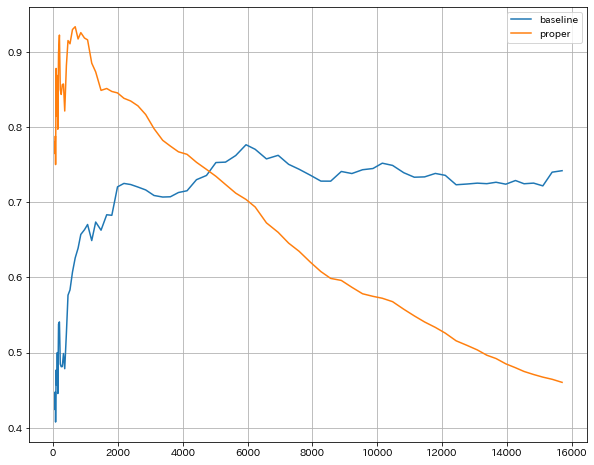

In [13]:
plt.figure(figsize=(10, 8))
gain_baseline.rename('baseline').plot(legend=True)
gain_proper.rename('proper').plot(legend=True)
plt.grid()

### 5．Optuna

In [14]:
# 訓練データ、検証データ、テストデータに分ける
train, test = split_data(r.data_c)
train, valid = split_data(train)

In [15]:
# 説明変数と目的変数に分ける
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_valid = valid.drop(['rank', 'date'], axis=1)
y_valid = valid['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

In [16]:
# データセットの作成
lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

# チューニング実行
params = {
    'objective': 'binary',
    'random_state': 100
}

lgb_clf_o = lgb_o.train(params, lgb_train, valid_sets=(lgb_train, lgb_valid), verbose_eval=100, early_stopping_rounds=10)

[I 2022-03-21 22:24:47,452] A new study created in memory with name: no-name-c758d765-c399-46bd-8763-722dd22528ac
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.461536:  14%|#4        | 1/7 [00:05<00:35,  5.91s/it]

Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.418478	valid_1's binary_logloss: 0.461536
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.461536:  29%|##8       | 2/7 [00:11<00:28,  5.71s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.41851	valid_1's binary_logloss: 0.461637
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.461515:  43%|####2     | 3/7 [00:17<00:23,  5.98s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.425856	valid_1's binary_logloss: 0.461515
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.461515:  57%|#####7    | 4/7 [00:23<00:17,  5.96s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.412918	valid_1's binary_logloss: 0.461826
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.461327:  71%|#######1  | 5/7 [00:30<00:12,  6.08s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.419281	valid_1's binary_logloss: 0.461327
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.461233:  86%|########5 | 6/7 [00:35<00:05,  5.77s/it]

Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.421293	valid_1's binary_logloss: 0.461233
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.461166:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.418859	valid_1's binary_logloss: 0.461166
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.461166:   5%|5         | 1/20 [00:14<04:39, 14.69s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.320678	valid_1's binary_logloss: 0.469801
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.461166:  10%|#         | 2/20 [00:22<03:47, 12.65s/it]

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.413242	valid_1's binary_logloss: 0.462646
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.461166:  15%|#5        | 3/20 [00:34<03:30, 12.37s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.355946	valid_1's binary_logloss: 0.467261
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.461166:  20%|##        | 4/20 [00:44<03:05, 11.62s/it]

Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.393562	valid_1's binary_logloss: 0.462512
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.461166:  25%|##5       | 5/20 [00:58<03:04, 12.33s/it]

Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.354225	valid_1's binary_logloss: 0.469806
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.461166:  30%|###       | 6/20 [01:12<03:00, 12.93s/it]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.361249	valid_1's binary_logloss: 0.466238
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.461166:  35%|###5      | 7/20 [01:28<02:58, 13.75s/it]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.361249	valid_1's binary_logloss: 0.466238
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.461166:  40%|####      | 8/20 [01:44<02:55, 14.62s/it]

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.371277	valid_1's binary_logloss: 0.464464
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.461166:  45%|####5     | 9/20 [01:57<02:34, 14.06s/it]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.414814	valid_1's binary_logloss: 0.461548
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.461166:  50%|#####     | 10/20 [02:23<02:55, 17.57s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.327145	valid_1's binary_logloss: 0.468828
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.463601	valid_1's binary_logloss: 0.465462
[200]	valid_0's binary_logloss: 0.455117	valid_1's binary_logloss: 0.462972
[300]	valid_0's binary_logloss: 0.448423	valid_1's binary_logloss: 0.461601


num_leaves, val_score: 0.461166:  55%|#####5    | 11/20 [02:37<02:29, 16.57s/it]

Early stopping, best iteration is:
[315]	valid_0's binary_logloss: 0.447411	valid_1's binary_logloss: 0.461425
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453318	valid_1's binary_logloss: 0.461445


num_leaves, val_score: 0.460855:  60%|######    | 12/20 [02:48<01:57, 14.73s/it]

Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.449691	valid_1's binary_logloss: 0.460855
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.468273	valid_1's binary_logloss: 0.468187
[200]	valid_0's binary_logloss: 0.46153	valid_1's binary_logloss: 0.464871
[300]	valid_0's binary_logloss: 0.456908	valid_1's binary_logloss: 0.463547
[400]	valid_0's binary_logloss: 0.453016	valid_1's binary_logloss: 0.462722


num_leaves, val_score: 0.460855:  65%|######5   | 13/20 [03:02<01:42, 14.65s/it]

Early stopping, best iteration is:
[437]	valid_0's binary_logloss: 0.45169	valid_1's binary_logloss: 0.46242
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.456364	valid_1's binary_logloss: 0.46288


num_leaves, val_score: 0.460855:  70%|#######   | 14/20 [03:11<01:17, 12.85s/it]

Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.446705	valid_1's binary_logloss: 0.461519
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.460855:  75%|#######5  | 15/20 [03:23<01:03, 12.61s/it]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.381476	valid_1's binary_logloss: 0.462793
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.460855:  80%|########  | 16/20 [03:30<00:44, 11.10s/it]

Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.431191	valid_1's binary_logloss: 0.461515
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.460855:  85%|########5 | 17/20 [03:41<00:32, 10.86s/it]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.389564	valid_1's binary_logloss: 0.463535
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.460855:  90%|######### | 18/20 [03:54<00:23, 11.61s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.351021	valid_1's binary_logloss: 0.467617
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.460855:  95%|#########5| 19/20 [04:06<00:11, 11.90s/it]

Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.354888	valid_1's binary_logloss: 0.464323
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.460855:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.338578	valid_1's binary_logloss: 0.466789
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453037	valid_1's binary_logloss: 0.464208


bagging, val_score: 0.460855:  10%|#         | 1/10 [00:05<00:50,  5.63s/it]

Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.446373	valid_1's binary_logloss: 0.463587
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452943	valid_1's binary_logloss: 0.462525


bagging, val_score: 0.460855:  20%|##        | 2/10 [00:12<00:47,  5.93s/it]

Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.443549	valid_1's binary_logloss: 0.460927
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.4534	valid_1's binary_logloss: 0.461933


bagging, val_score: 0.460855:  30%|###       | 3/10 [00:19<00:43,  6.24s/it]

Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.449066	valid_1's binary_logloss: 0.460965
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453032	valid_1's binary_logloss: 0.462025


bagging, val_score: 0.460855:  40%|####      | 4/10 [00:25<00:37,  6.19s/it]

Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.450406	valid_1's binary_logloss: 0.461462
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.45298	valid_1's binary_logloss: 0.462972


bagging, val_score: 0.460855:  50%|#####     | 5/10 [00:31<00:30,  6.05s/it]

Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.446417	valid_1's binary_logloss: 0.462139
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.460855:  60%|######    | 6/10 [00:36<00:23,  5.76s/it]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.455214	valid_1's binary_logloss: 0.462744
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453159	valid_1's binary_logloss: 0.462417


bagging, val_score: 0.460855:  70%|#######   | 7/10 [00:42<00:17,  5.91s/it]

Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.448782	valid_1's binary_logloss: 0.461545
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453113	valid_1's binary_logloss: 0.46193


bagging, val_score: 0.460855:  80%|########  | 8/10 [00:49<00:12,  6.15s/it]

Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.4472	valid_1's binary_logloss: 0.461305
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453742	valid_1's binary_logloss: 0.463982


bagging, val_score: 0.460855:  90%|######### | 9/10 [00:54<00:05,  5.88s/it]

Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.448866	valid_1's binary_logloss: 0.46318
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.460855:   0%|          | 0/3 [00:00<?, ?it/s]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.459086	valid_1's binary_logloss: 0.464355
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453323	valid_1's binary_logloss: 0.462395


feature_fraction_stage2, val_score: 0.460805:  33%|###3      | 1/3 [00:07<00:15,  7.60s/it]

Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.441722	valid_1's binary_logloss: 0.460805
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453175	valid_1's binary_logloss: 0.461748


feature_fraction_stage2, val_score: 0.460488:  67%|######6   | 2/3 [00:14<00:07,  7.47s/it]

Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.441518	valid_1's binary_logloss: 0.460488
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453535	valid_1's binary_logloss: 0.462232


regularization_factors, val_score: 0.460488:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.452304	valid_1's binary_logloss: 0.461871
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453321	valid_1's binary_logloss: 0.461804


regularization_factors, val_score: 0.459987:   5%|5         | 1/20 [00:07<02:26,  7.74s/it]

Early stopping, best iteration is:
[183]	valid_0's binary_logloss: 0.440934	valid_1's binary_logloss: 0.459987
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453254	valid_1's binary_logloss: 0.461675


regularization_factors, val_score: 0.459987:  10%|#         | 2/20 [00:14<02:14,  7.48s/it]

Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 0.444571	valid_1's binary_logloss: 0.460478
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453253	valid_1's binary_logloss: 0.461678


regularization_factors, val_score: 0.459978:  15%|#5        | 3/20 [00:22<02:11,  7.73s/it]

Early stopping, best iteration is:
[187]	valid_0's binary_logloss: 0.440503	valid_1's binary_logloss: 0.459978
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453243	valid_1's binary_logloss: 0.461369


regularization_factors, val_score: 0.459978:  20%|##        | 4/20 [00:30<02:01,  7.62s/it]

Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.444084	valid_1's binary_logloss: 0.460326
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453181	valid_1's binary_logloss: 0.462008


regularization_factors, val_score: 0.459978:  25%|##5       | 5/20 [00:37<01:52,  7.51s/it]

Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.446207	valid_1's binary_logloss: 0.461252
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453175	valid_1's binary_logloss: 0.461749


regularization_factors, val_score: 0.459978:  30%|###       | 6/20 [00:45<01:45,  7.56s/it]

Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.441518	valid_1's binary_logloss: 0.46049
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453982	valid_1's binary_logloss: 0.461425


regularization_factors, val_score: 0.459978:  35%|###5      | 7/20 [00:52<01:36,  7.43s/it]

Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.451945	valid_1's binary_logloss: 0.46107
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453374	valid_1's binary_logloss: 0.462061


regularization_factors, val_score: 0.459978:  40%|####      | 8/20 [00:58<01:25,  7.16s/it]

Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.450947	valid_1's binary_logloss: 0.461755
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453175	valid_1's binary_logloss: 0.461751


regularization_factors, val_score: 0.459978:  45%|####5     | 9/20 [01:07<01:24,  7.70s/it]

Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.441518	valid_1's binary_logloss: 0.460489
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453254	valid_1's binary_logloss: 0.461678


regularization_factors, val_score: 0.459978:  50%|#####     | 10/20 [01:15<01:17,  7.77s/it]

Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 0.444575	valid_1's binary_logloss: 0.46048
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453177	valid_1's binary_logloss: 0.461751


regularization_factors, val_score: 0.459978:  55%|#####5    | 11/20 [01:23<01:10,  7.82s/it]

Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.447183	valid_1's binary_logloss: 0.46101
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.455124	valid_1's binary_logloss: 0.461373
[200]	valid_0's binary_logloss: 0.443785	valid_1's binary_logloss: 0.459305


regularization_factors, val_score: 0.458442:  60%|######    | 12/20 [01:35<01:11,  8.96s/it]

Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.438202	valid_1's binary_logloss: 0.458442
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.454901	valid_1's binary_logloss: 0.461437


regularization_factors, val_score: 0.458442:  65%|######5   | 13/20 [01:45<01:05,  9.40s/it]

[200]	valid_0's binary_logloss: 0.443319	valid_1's binary_logloss: 0.459513
Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 0.444389	valid_1's binary_logloss: 0.459459
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.454336	valid_1's binary_logloss: 0.461563
[200]	valid_0's binary_logloss: 0.441952	valid_1's binary_logloss: 0.459452


regularization_factors, val_score: 0.458442:  70%|#######   | 14/20 [01:57<00:59,  9.95s/it]

Early stopping, best iteration is:
[203]	valid_0's binary_logloss: 0.441593	valid_1's binary_logloss: 0.459295
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.45523	valid_1's binary_logloss: 0.462007
[200]	valid_0's binary_logloss: 0.443699	valid_1's binary_logloss: 0.459138


regularization_factors, val_score: 0.458442:  75%|#######5  | 15/20 [02:09<00:53, 10.71s/it]

Early stopping, best iteration is:
[230]	valid_0's binary_logloss: 0.440558	valid_1's binary_logloss: 0.458782
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.454403	valid_1's binary_logloss: 0.461911


regularization_factors, val_score: 0.458442:  80%|########  | 16/20 [02:18<00:40, 10.08s/it]

Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.451096	valid_1's binary_logloss: 0.46126
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.454752	valid_1's binary_logloss: 0.461055
[200]	valid_0's binary_logloss: 0.442898	valid_1's binary_logloss: 0.458997


regularization_factors, val_score: 0.458442:  85%|########5 | 17/20 [02:30<00:32, 10.68s/it]

Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 0.442122	valid_1's binary_logloss: 0.458858
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453342	valid_1's binary_logloss: 0.461504


regularization_factors, val_score: 0.458442:  90%|######### | 18/20 [02:38<00:20, 10.00s/it]

Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.446883	valid_1's binary_logloss: 0.460547
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452949	valid_1's binary_logloss: 0.461863


regularization_factors, val_score: 0.458442:  95%|#########5| 19/20 [02:46<00:09,  9.32s/it]

Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.45311	valid_1's binary_logloss: 0.461805
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.453487	valid_1's binary_logloss: 0.46156


min_data_in_leaf, val_score: 0.458442:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.446893	valid_1's binary_logloss: 0.460337
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.455124	valid_1's binary_logloss: 0.461373
[200]	valid_0's binary_logloss: 0.443653	valid_1's binary_logloss: 0.459182


min_data_in_leaf, val_score: 0.458442:  20%|##        | 1/5 [00:11<00:47, 11.96s/it]

Early stopping, best iteration is:
[216]	valid_0's binary_logloss: 0.44204	valid_1's binary_logloss: 0.459043
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.455124	valid_1's binary_logloss: 0.461373


min_data_in_leaf, val_score: 0.458442:  40%|####      | 2/5 [00:23<00:35, 11.72s/it]

Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 0.445101	valid_1's binary_logloss: 0.459158
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.45505	valid_1's binary_logloss: 0.461401
[200]	valid_0's binary_logloss: 0.443537	valid_1's binary_logloss: 0.459073


min_data_in_leaf, val_score: 0.458442:  60%|######    | 3/5 [00:36<00:24, 12.20s/it]

Early stopping, best iteration is:
[241]	valid_0's binary_logloss: 0.43957	valid_1's binary_logloss: 0.458659
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.455124	valid_1's binary_logloss: 0.461373
[200]	valid_0's binary_logloss: 0.443786	valid_1's binary_logloss: 0.459315


min_data_in_leaf, val_score: 0.458442:  80%|########  | 4/5 [00:48<00:12, 12.23s/it]

Early stopping, best iteration is:
[245]	valid_0's binary_logloss: 0.439139	valid_1's binary_logloss: 0.458524
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.455207	valid_1's binary_logloss: 0.461869
[200]	valid_0's binary_logloss: 0.443826	valid_1's binary_logloss: 0.459373


min_data_in_leaf, val_score: 0.458442: 100%|##########| 5/5 [01:00<00:00, 12.03s/it]

Early stopping, best iteration is:
[208]	valid_0's binary_logloss: 0.44297	valid_1's binary_logloss: 0.459299


1．あるハイパーパラメータを使って、lgb_trainで学習<br>
2．そのモデルを使ってlgb_validで検証<br>
3．検証結果を利用して、ハイパーパラメータを変えてlgb_trainで再学習<br>
4．2～3を繰り返す

In [17]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 8.767623686340933,
 'lambda_l2': 0.00047800275786932393,
 'num_leaves': 7,
 'feature_fraction': 0.9840000000000001,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [18]:
# 時系列に沿って訓練データとテストデータに分ける
train, test = split_data(r.data_c)
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

In [19]:
lgb_clf = lgb.LGBMClassifier(**lgb_clf_o.params)
lgb_clf.fit(X_train.values, y_train.values)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=0,
               feature_fraction=0.9840000000000001, feature_pre_filter=False,
               lambda_l1=8.767623686340933, lambda_l2=0.00047800275786932393,
               num_leaves=7, objective='binary', random_state=100)

In [20]:
me = ModelEvaluator(lgb_clf, 'return_tables.pickle')

In [21]:
me.feature_importance(X_test)

,features,importance
4,jockey_id,55
3,horse_id,40
7,体重,33
10,賞金_5R,30
26,賞金_race_type_5R,29
1,馬番,21
5,course_len,20
25,着順_race_type_5R,16
2,斤量,15
75,着差_allR,15


In [22]:
gain_optuna = gain(me.tansho_return_proper, X_test)
gain_optuna.to_pickle('gain_optuna.pickle')

100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


In [23]:
gain_optuna = pd.read_pickle('gain_optuna.pickle')

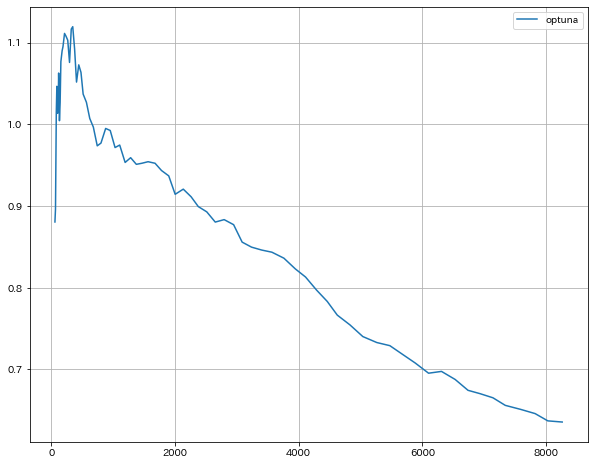

In [24]:
plt.figure(figsize=(10, 8))
gain_optuna.rename('optuna').plot(legend=True)
plt.grid()

In [25]:
gain_optuna.max()

1.1195571351571942

### 6．単勝以外の馬券

In [26]:
me = ModelEvaluator(lgb_clf, 'return_tables.pickle')
me.umaren_return(X_test)

(14250.0, 0.6111578947368421)

In [27]:
# gain_umaren = gain(me.umaren_return, X_test)
# gain_umaren.to_pickle('gain_umaren.pickle')

In [28]:
gain_umaren= pd.read_pickle('gain_umaren.pickle')

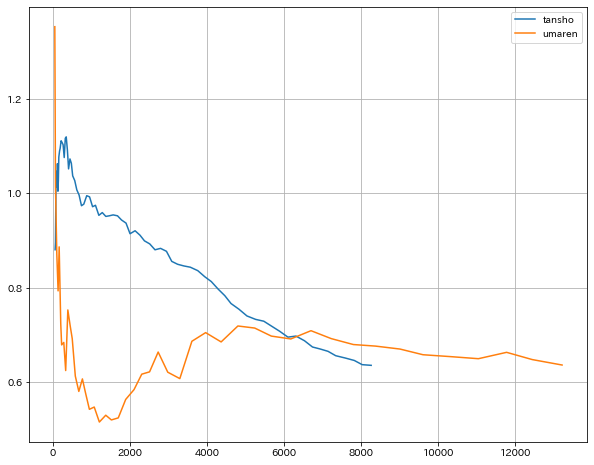

In [29]:
plt.figure(figsize=(10, 8))
gain_optuna.rename('tansho').plot(legend=True)
gain_umaren.rename('umaren').plot(legend=True)
plt.grid()